<a href="https://colab.research.google.com/github/ekity1002/pytorch_codes/blob/master/semantic_segmentation_PSPNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/YutaroOgawa/pytorch_advanced.git
% cd /content/pytorch_advanced/3_semantic_segmentation

Cloning into 'pytorch_advanced'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 479 (delta 13), reused 23 (delta 8), pack-reused 441
Receiving objects: 100% (479/479), 15.09 MiB | 31.60 MiB/s, done.
Resolving deltas: 100% (244/244), done.
/content/pytorch_advanced/3_semantic_segmentation


# dataset　DL

In [2]:
import os
import urllib.request
import zipfile
import tarfile

In [3]:
# フォルダ「data」が存在しない場合は作成する
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [4]:
# フォルダ「weights」が存在しない場合は作成する
weights_dir = "./weights/"
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

In [5]:
# VOC2012のデータセットをここからダウンロードします
# 時間がかかります（約15分）
url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar"
target_path = os.path.join(data_dir, "VOCtrainval_11-May-2012.tar") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)
    
    tar = tarfile.TarFile(target_path)  # tarファイルを読み込み
    tar.extractall(data_dir)  # tarを解凍
    tar.close()  # tarファイルをクローズ

In [6]:
# フォルダ「weights」にネットワークの初期値として使用する「pspnet50_ADE20K.pth」を
# 筆者のGoogle Driveから手動でダウンロードする
    
#https://drive.google.com/open?id=12eN6SpnawYuQmD1k9VgVW3QSgPR6hICc

In [7]:
# 【※（実施済み）】
# 乗馬の画像を手動でダウンロード

# https://pixabay.com/ja/photos/%E3%82%AB%E3%82%A6%E3%83%9C%E3%83%BC%E3%82%A4-%E9%A6%AC-%E4%B9%97%E9%A6%AC-%E6%B0%B4-%E6%B5%B7-757575/
# の640×426サイズの画像
# （画像権利情報：商用利用無料、帰属表示は必要ありません）

# を、フォルダ「data」の直下に置く。

In [8]:
# 本章の内容で筆者が作成した学習済みのPSPNetモデル「pspnet50_30.pth」

# https://drive.google.com/open?id=192JenT9UTHjFb6fhwSdRgOWr8_RmDl4I
    
# 必ずしもダウンロードの必要はありませんが、
# 自分でPSPNetを学習させる前に、学習済みモデルをさわりたい場合は、
# 手動でダウンロードした「pspnet50_30.pth」をフォルダ「wights」に配置してください。

# 3-2 Dataset, Dataloader構築

In [9]:
# パッケージのimport
import os.path as osp
from PIL import Image

import torch.utils.data as data

In [10]:
def make_datapath_list(rootpath):
    # 画像ファイルとアノテーションファイルへのパスのテンプレートを作成
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = osp.join(rootpath, 'SegmentationClass', '%s.png')

    # 訓練と検証、それぞれのファイルのID（ファイル名）を取得する
    train_id_names = osp.join(rootpath + 'ImageSets/Segmentation/train.txt')
    val_id_names = osp.join(rootpath + 'ImageSets/Segmentation/val.txt')

    # 訓練データの画像ファイルとアノテーションファイルへのパスリストを作成
    train_img_list = list()
    train_anno_list = list()

    for line in open(train_id_names):
        file_id = line.strip()  # 空白スペースと改行を除去
        img_path = (imgpath_template % file_id)  # 画像のパス
        anno_path = (annopath_template % file_id)  # アノテーションのパス
        train_img_list.append(img_path)
        train_anno_list.append(anno_path)

    # 検証データの画像ファイルとアノテーションファイルへのパスリストを作成
    val_img_list = list()
    val_anno_list = list()

    for line in open(val_id_names):
        file_id = line.strip()  # 空白スペースと改行を除去
        img_path = (imgpath_template % file_id)  # 画像のパス
        anno_path = (annopath_template % file_id)  # アノテーションのパス
        val_img_list.append(img_path)
        val_anno_list.append(anno_path)

    return train_img_list, train_anno_list, val_img_list, val_anno_list

In [11]:
# 動作確認 ファイルパスのリストを取得
rootpath = "./data/VOCdevkit/VOC2012/"

train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath)

print(train_img_list[0])
print(train_anno_list[0])

./data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg
./data/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png


# 前処理関数

In [12]:
# 第3章セマンティックセグメンテーションのデータオーギュメンテーション
# 注意　アノテーション画像はカラーパレット形式（インデックスカラー画像）となっている。

# パッケージのimport
import torch
from torchvision import transforms
from PIL import Image, ImageOps, ImageFilter
import numpy as np


class Compose(object):
    """引数transformに格納された変形を順番に実行するクラス
       対象画像とアノテーション画像を同時に変換させます。 
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, anno_class_img):
        for t in self.transforms:
            img, anno_class_img = t(img, anno_class_img)
        return img, anno_class_img


class Scale(object):
    def __init__(self, scale):
        self.scale = scale

    def __call__(self, img, anno_class_img):

        width = img.size[0]  # img.size=[幅][高さ]
        height = img.size[1]  # img.size=[幅][高さ]

        # 拡大倍率をランダムに設定
        scale = np.random.uniform(self.scale[0], self.scale[1])

        scaled_w = int(width * scale)  # img.size=[幅][高さ]
        scaled_h = int(height * scale)  # img.size=[幅][高さ]

        # 画像のリサイズ
        img = img.resize((scaled_w, scaled_h), Image.BICUBIC)

        # アノテーションのリサイズ
        anno_class_img = anno_class_img.resize(
            (scaled_w, scaled_h), Image.NEAREST)

        # 画像を元の大きさに
        # 切り出し位置を求める
        if scale > 1.0:
            left = scaled_w - width
            left = int(np.random.uniform(0, left))

            top = scaled_h-height
            top = int(np.random.uniform(0, top))

            img = img.crop((left, top, left+width, top+height))
            anno_class_img = anno_class_img.crop(
                (left, top, left+width, top+height))

        else:
            # input_sizeよりも短い辺はpaddingする
            p_palette = anno_class_img.copy().getpalette()

            img_original = img.copy()
            anno_class_img_original = anno_class_img.copy()

            pad_width = width-scaled_w
            pad_width_left = int(np.random.uniform(0, pad_width))

            pad_height = height-scaled_h
            pad_height_top = int(np.random.uniform(0, pad_height))

            img = Image.new(img.mode, (width, height), (0, 0, 0))
            img.paste(img_original, (pad_width_left, pad_height_top))

            anno_class_img = Image.new(
                anno_class_img.mode, (width, height), (0))
            anno_class_img.paste(anno_class_img_original,
                                 (pad_width_left, pad_height_top))
            anno_class_img.putpalette(p_palette)

        return img, anno_class_img


class RandomRotation(object):
    def __init__(self, angle):
        self.angle = angle

    def __call__(self, img, anno_class_img):

        # 回転角度を決める
        rotate_angle = (np.random.uniform(self.angle[0], self.angle[1]))

        # 回転
        img = img.rotate(rotate_angle, Image.BILINEAR)
        anno_class_img = anno_class_img.rotate(rotate_angle, Image.NEAREST)

        return img, anno_class_img


class RandomMirror(object):
    """50%の確率で左右反転させるクラス"""

    def __call__(self, img, anno_class_img):
        if np.random.randint(2):
            img = ImageOps.mirror(img)
            anno_class_img = ImageOps.mirror(anno_class_img)
        return img, anno_class_img


class Resize(object):
    """引数input_sizeに大きさを変形するクラス"""

    def __init__(self, input_size):
        self.input_size = input_size

    def __call__(self, img, anno_class_img):

        # width = img.size[0]  # img.size=[幅][高さ]
        # height = img.size[1]  # img.size=[幅][高さ]

        img = img.resize((self.input_size, self.input_size),
                         Image.BICUBIC)
        anno_class_img = anno_class_img.resize(
            (self.input_size, self.input_size), Image.NEAREST)

        return img, anno_class_img


class Normalize_Tensor(object):
    def __init__(self, color_mean, color_std):
        self.color_mean = color_mean
        self.color_std = color_std

    def __call__(self, img, anno_class_img):

        # PIL画像をTensorに。大きさは最大1に規格化される
        img = transforms.functional.to_tensor(img)

        # 色情報の標準化
        img = transforms.functional.normalize(
            img, self.color_mean, self.color_std)

        # アノテーション画像をNumpyに変換
        anno_class_img = np.array(anno_class_img)  # [高さ][幅]

        # 'ambigious'には255が格納されているので、0の背景にしておく
        index = np.where(anno_class_img == 255)
        anno_class_img[index] = 0

        # アノテーション画像をTensorに
        anno_class_img = torch.from_numpy(anno_class_img)

        return img, anno_class_img

In [13]:
# データ処理のクラスとデータオーギュメンテーションのクラスをimportする
from utils.data_augumentation import Compose, Scale, RandomRotation, RandomMirror, Resize, Normalize_Tensor


class DataTransform():
    """
    画像とアノテーションの前処理クラス。訓練時と検証時で異なる動作をする。
    画像のサイズをinput_size x input_sizeにする。
    訓練時はデータオーギュメンテーションする。


    Attributes
    ----------
    input_size : int
        リサイズ先の画像の大きさ。
    color_mean : (R, G, B)
        各色チャネルの平均値。
    color_std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, input_size, color_mean, color_std):
        self.data_transform = {
            'train': Compose([
                Scale(scale=[0.5, 1.5]),  # 画像の拡大
                RandomRotation(angle=[-10, 10]),  # 回転
                RandomMirror(),  # ランダムミラー
                Resize(input_size),  # リサイズ(input_size)
                Normalize_Tensor(color_mean, color_std)  # 色情報の標準化とテンソル化
            ]),
            'val': Compose([
                Resize(input_size),  # リサイズ(input_size)
                Normalize_Tensor(color_mean, color_std)  # 色情報の標準化とテンソル化
            ])
        }

    def __call__(self, phase, img, anno_class_img):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img, anno_class_img)


class VOCDataset(data.Dataset):
    """
    VOC2012のDatasetを作成するクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    img_list : リスト
        画像のパスを格納したリスト
    anno_list : リスト
        アノテーションへのパスを格納したリスト
    phase : 'train' or 'test'
        学習か訓練かを設定する。
    transform : object
        前処理クラスのインスタンス
    """

    def __init__(self, img_list, anno_list, phase, transform):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transform = transform

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.img_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとアノテーションを取得
        '''
        img, anno_class_img = self.pull_item(index)
        return img, anno_class_img

    def pull_item(self, index):
        '''画像のTensor形式のデータ、アノテーションを取得する'''

        # 1. 画像読み込み
        image_file_path = self.img_list[index]
        img = Image.open(image_file_path)   # [高さ][幅][色RGB]

        # 2. アノテーション画像読み込み
        anno_file_path = self.anno_list[index]
        anno_class_img = Image.open(anno_file_path)   # [高さ][幅]

        # 3. 前処理を実施
        img, anno_class_img = self.transform(self.phase, img, anno_class_img)

        return img, anno_class_img

In [14]:
# 動作確認

# (RGB)の色の平均値と標準偏差
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)

# データセット作成
train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

# データの取り出し例
print(val_dataset.__getitem__(0)[0].shape)
print(val_dataset.__getitem__(0)[1].shape)
print(val_dataset.__getitem__(0))

torch.Size([3, 475, 475])
torch.Size([475, 475])
(tensor([[[ 1.6667,  1.5125,  1.5639,  ...,  1.7523,  1.6667,  1.7009],
         [ 1.5810,  1.4269,  1.4783,  ...,  1.7009,  1.6153,  1.6495],
         [ 1.5639,  1.4098,  1.4440,  ...,  1.6838,  1.5982,  1.6324],
         ...,
         [-0.4739, -0.4911, -0.5424,  ...,  1.2557,  1.1872,  1.2214],
         [-0.5596, -0.4911, -0.4911,  ...,  1.2385,  1.1872,  1.2214],
         [-0.6281, -0.3883, -0.3369,  ...,  1.2385,  1.1872,  1.2214]],

        [[ 1.8333,  1.6758,  1.7283,  ...,  1.9209,  1.8333,  1.8683],
         [ 1.7458,  1.5882,  1.6408,  ...,  1.8683,  1.7808,  1.8158],
         [ 1.7283,  1.5707,  1.6057,  ...,  1.8508,  1.7633,  1.7983],
         ...,
         [-0.5826, -0.6001, -0.6527,  ...,  1.4132,  1.3431,  1.3431],
         [-0.6702, -0.6001, -0.6001,  ...,  1.3957,  1.3431,  1.3431],
         [-0.7402, -0.4951, -0.4426,  ...,  1.3957,  1.3431,  1.3431]],

        [[ 2.0474,  1.8905,  1.9428,  ...,  2.1346,  2.0474,  2.08

In [15]:
# データローダーの作成
batch_size = 8

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書オブジェクトにまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作の確認
batch_iterator = iter(dataloaders_dict["val"])  # イタレータに変換
imges, anno_class_imges = next(batch_iterator)  # 1番目の要素を取り出す
print(imges.size())  # torch.Size([8, 3, 475, 475])
print(anno_class_imges.size())  # torch.Size([8, 3, 475, 475])

torch.Size([8, 3, 475, 475])
torch.Size([8, 475, 475])


# datasetから描画

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


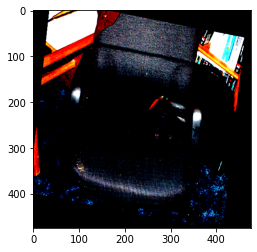

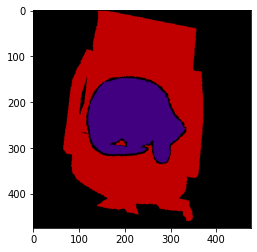

In [16]:

# 実行するたびに変わります
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 画像データの読み込み
index = 2
imges, anno_class_imges = train_dataset.__getitem__(index)

# 画像の表示
img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
plt.imshow(img_val)
plt.show()

# アノテーション画像の表示
anno_file_path = train_anno_list[0]
anno_class_img = Image.open(anno_file_path)   # [高さ][幅][色RGB]
p_palette = anno_class_img.getpalette()

anno_class_img_val = anno_class_imges.numpy()
anno_class_img_val = Image.fromarray(np.uint8(anno_class_img_val), mode="P")
anno_class_img_val.putpalette(p_palette)
plt.imshow(anno_class_img_val)
plt.show()

# 検証画像の描画

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 475, 475])
(475, 475, 3)


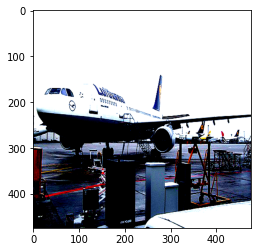

(475, 475)


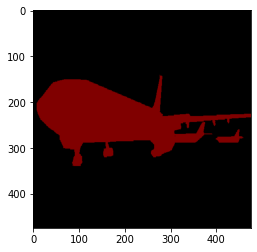

In [61]:
# 画像データの読み込み
index = 0
imges, anno_class_imges = val_dataset.__getitem__(index)

# 画像の表示
img_val = imges
print(img_val.shape) #channel, width, height
img_val = img_val.numpy().transpose((1, 2, 0))
print(img_val.shape) #width, height, channel
plt.imshow(img_val)
plt.show()

# アノテーション画像の表示
anno_file_path = train_anno_list[0]
anno_class_img = Image.open(anno_file_path)   # [高さ][幅][色RGB]
#print(anno_class_img.size, anno_class_img)
p_palette = anno_class_img.getpalette()
#print(p_palette)
anno_class_img_val = anno_class_imges.numpy()
print(anno_class_img_val.shape)
anno_class_img_val = Image.fromarray(np.uint8(anno_class_img_val), mode="P")
anno_class_img_val.putpalette(p_palette)
plt.imshow(anno_class_img_val)
plt.show()

# モデル構築

In [18]:
# パッケージのimport
import torch
import torch.nn as nn
import torch.nn.functional as F

class PSPNet(nn.Module):
    def __init__(self, n_classes):
        super(PSPNet, self).__init__()

        #parameter
        # config 引数から渡せるようにするといい
        block_config = [3, 4, 6, 3] #resnet50
        img_size = 475
        img_size_8 = 60 #img_size の1/8に

        # 4つのモジュールを構成するサブネットワークの用意
        self.feature_conv = FeatureMap_convolution()

        self.feature_res_1 = ResidualBlockPSP(
            n_blocks=block_config[0], in_channels=128, mid_channels=64, out_channels=256, stride=1, dilation=1)
        self.feature_res_2 = ResidualBlockPSP(
            n_blocks=block_config[1], in_channels=256, mid_channels=128, out_channels=512, stride=2, dilation=1)
        
        self.feature_dilated_res_1 = ResidualBlockPSP(
            n_blocks=block_config[2], in_channels=512, mid_channels=256, out_channels=1024, stride=1, dilation=2)
        self.feature_dilated_res_2 = ResidualBlockPSP(
            n_blocks=block_config[3], in_channels=1024, mid_channels=512, out_channels=2048, stride=1, dilation=4)

        self.pyramid_pooling = PyramidPooling(in_channels=2048, pool_sizes=[6, 3, 2, 1], height=img_size_8, width=img_size_8)

        self.decode_feature = DecodePSPFeature(height=img_size, width=img_size, n_classes=n_classes)

        self.aux = AuxiliaryPSPlayers(
            in_channels=1024, height=img_size, width=img_size, n_classes=n_classes)

    def forward(self, x):
        x = self.feature_conv(x)
        x = self.feature_res_1(x)
        x = self.feature_res_2(x)
        x = self.feature_dilated_res_1(x)

        output_aux = self.aux(x) #Featureモジュールの途中をauxモジュールへ

        x = self.feature_dilated_res_2(x)

        x = self.pyramid_pooling(x)
        output = self.decode_feature(x)

        return (output, output_aux)


In [19]:
class FeatureMap_convolution(nn.Module):
    def __init__(self):
        '''構成するネットワークを用意'''
        super(FeatureMap_convolution, self).__init__()

        # 畳み込み層1
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 3, 64, 3, 2, 1, 1, False
        self.cbnr_1 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        # 畳み込み層2
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 64, 64, 3, 1, 1, 1, False
        self.cbnr_2 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        # 畳み込み層3
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 64, 128, 3, 1, 1, 1, False
        self.cbnr_3 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        # MaxPooling層
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = self.cbnr_1(x)
        x = self.cbnr_2(x)
        x = self.cbnr_3(x)
        outputs = self.maxpool(x)
        return outputs
        
class conv2DBatchNormRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, bias):
        super(conv2DBatchNormRelu, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, bias=bias)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True) #inplace設定で入力を保存せずに出力を計算しメモリ削減

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        outputs = self.relu(x)
        return outputs

In [20]:
class ResidualBlockPSP(nn.Sequential):
    def __init__(self, n_blocks, in_channels, mid_channels, out_channels, stride, dilation):
        super(ResidualBlockPSP, self).__init__()

        # bottleNeckPSPの用意
        self.add_module(
            'block1', bottleNeckPSP(in_channels, mid_channels, out_channels, stride, dilation)
        )

        # bottleNeckIdentifyPSPの繰り返しの用意
        for i in range(n_blocks - 1):
            self.add_module(
                "block" + str(i+2),
                bottleNeckIdentifyPSP(
                    out_channels, mid_channels, stride, dilation)
            )

class conv2DBatchNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, bias):
        super(conv2DBatchNorm, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size, stride, padding, dilation, bias=bias)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        outputs = self.batchnorm(x)

        return outputs

In [21]:
class bottleNeckPSP(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, stride, dilation):
        super(bottleNeckPSP, self).__init__()

        # 1x1, 3x3, 1x1の畳み込み (bottleneck)
        self.cbr_1 = conv2DBatchNormRelu(
            in_channels, mid_channels,  kernel_size=1, stride=1, padding=0, dilation=1, bias=False
        )
        self.cbr_2 = conv2DBatchNormRelu(
            mid_channels, mid_channels, kernel_size=3, stride=stride, padding=dilation, dilation=dilation, bias=False)
        self.cb_3 = conv2DBatchNorm(
            mid_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        
        # skip connecttion
        self.cb_residual = conv2DBatchNorm(
            in_channels, out_channels, kernel_size=1, stride=stride, padding=0, dilation=1, bias=False)
        
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        conv = self.cb_3(self.cbr_2(self.cbr_1(x)))
        residual = self.cb_residual(x)
        return self.relu(conv + residual)

class bottleNeckIdentifyPSP(nn.Module):
    def __init__(self, in_channels, mid_channels, stride, dilation):
        super(bottleNeckIdentifyPSP, self).__init__()

        self.cbr_1 = conv2DBatchNormRelu(
            in_channels, mid_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.cbr_2 = conv2DBatchNormRelu(
            mid_channels, mid_channels, kernel_size=3, stride=1, padding=dilation, dilation=dilation, bias=False)
        self.cb_3 = conv2DBatchNorm(
            mid_channels, in_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        conv = self.cb_3(self.cbr_2(self.cbr_1(x)))
        residual = x
        return self.relu(conv + residual)

In [22]:
class PyramidPooling(nn.Module):
    def __init__(self, in_channels, pool_sizes, height, width):
        super(PyramidPooling, self).__init__()

        # forwardで使用する画像サイズ
        self.height = height
        self.width = width

        # 各畳込みの出力チャネル数
        out_channels = int(in_channels / len(pool_sizes))

        # 各畳み込み層を作成
        # この実装方法は愚直すぎてfor文で書きたいところですが、分かりやすさを優先しています
        # pool_sizes: [6, 3, 2, 1]
        self.avpool_1 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[0])
        self.cbr_1 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.avpool_2 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[1])
        self.cbr_2 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.avpool_3 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[2])
        self.cbr_3 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.avpool_4 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[3])
        self.cbr_4 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

    def fowrard(self, x):
        out1 = self.cbr_1(self.avpool_1(x))
        out1 = F.interpolate(out1, size=(  #プーリング結果のアップサンプリング。bilinear: 
            self.height, self.width), mode="bilinear", align_corners=True)

        out2 = self.cbr_2(self.avpool_2(x))
        out2 = F.interpolate(out2, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        out3 = self.cbr_3(self.avpool_3(x))
        out3 = F.interpolate(out3, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        out4 = self.cbr_4(self.avpool_4(x))
        out4 = F.interpolate(out4, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        # 最終的に結合させる、dim=1でチャネル数の次元で結合
        output = torch.cat([x, out1, out2, out3, out4], dim=1)

        return output

In [23]:
# decoder, auxloss
class DecodePSPFeature(nn.Module):
    def __init__(self, height, width, n_classes):
        super(DecodePSPFeature, self).__init__()

        # forwardで使用する画像サイズ
        self.height = height
        self.width = width

        self.cbr = conv2DBatchNormRelu(
            in_channels=4096, out_channels=512, kernel_size=3, stride=1, padding=1, dilation=1, bias=False
        )
        self.dropout = nn.Dropout2d(p=0.1)
        # 分類に 線形層でなく1x1の畳み込み pointwise conv を使うのがポイント!
        self.classification = nn.Conv2d(
            in_channels=512, out_channels=n_classes, kernel_size=1, stride=1, padding=0
        )

    def forward(self, x):
        x = self.cbr(x)
        x = self.dropout(x)
        x = self.classification(x)
        output = F.interpolate(
            x, size=(self.height, self.width), mode='bilinear', align_corners=True
        )
        return output

class AuxiliaryPSPlayers(nn.Module):
    def __init__(self, in_channels, height, width, n_classes):
        super(AuxiliaryPSPlayers, self).__init__()
        
        # forwardで使用する画像サイズ
        self.height = height
        self.width = width

        self.cbr = conv2DBatchNormRelu(
            in_channels=in_channels, out_channels=256, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
        self.dropout = nn.Dropout2d(p=0.1)
        # 分類に 線形層でなく1x1の畳み込み pointwise conv を使うのがポイント!
        self.classification = nn.Conv2d(
            in_channels=256, out_channels=n_classes, kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        x = self.cbr(x)
        x = self.dropout(x)
        x = self.classification(x)
        output = F.interpolate(x, size=(self.height, self.width), mode="bilinear", align_corners=True)
        return output

# モデル学習

In [24]:

# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

In [25]:
# 初期設定
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [26]:
from utils.dataloader import make_datapath_list, DataTransform, VOCDataset

# ファイルパスリスト作成
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath)

# Dataset作成
# (RGB)の色の平均値と標準偏差
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

# DataLoader作成
batch_size = 8

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

In [28]:
# モデル作成
from utils.pspnet import PSPNet

net = PSPNet(n_classes=10)

# ADE20K学習済みパラメータをロード
state_dict = torch.load("./weights/pspnet50_ADE20K.pth")
net.load_state_dict(state_dict)

# 分類用の畳み込みそうを出力数２１のものにつけかえる
n_classes=21
net.decode_feature.classification = nn.Conv2d(
    in_channels=512, out_channels=n_classes, kernel_size=1, stride=1, padding=0
)

# 付け替えた畳み込みそうを活性化する。活性化関数がsigmoidなのでxavierを使用
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight.data)
        if m.bias is not None: #バイアスがある場合
            nn.init.constant_(m_bias, 0.0)

net.decode_feature.classification.apply(weights_init)
net.aux_classification.apply(weighs_init)

FileNotFoundError: ignored

In [32]:
class PSPLoss(nn.Module):
    def __init__(self, aux_weight=0.4):
        super(PSPLoss, self).__init__()
        self.aux_weight = aux_weight

    def forward(self, outputs, targets):
        loss = F.cross_entropy(outputs[0], targets, reduction='mean')
        loss_aux = F.cross_entropy(outputs[1], targets, reduction='mean')

        return loss + self.aux_weight*loss_auc


In [33]:
criterion = PSPLoss(aux_weight=0.4)
optimizer = optim.SGD([
    {'params': net.feature_conv.parameters(), 'lr': 1e-3},
    {'params': net.feature_res_1.parameters(), 'lr': 1e-3},
    {'params': net.feature_res_2.parameters(), 'lr': 1e-3},
    {'params': net.feature_dilated_res_1.parameters(), 'lr': 1e-3},
    {'params': net.feature_dilated_res_2.parameters(), 'lr': 1e-3},
    {'params': net.pyramid_pooling.parameters(), 'lr': 1e-3},
    {'params': net.decode_feature.parameters(), 'lr': 1e-2},
    {'params': net.aux.parameters(), 'lr': 1e-2},
],
    momentum=0.9, weight_decay=0.0001  
)

# 推論

In [34]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch

In [35]:

from utils.dataloader import make_datapath_list, DataTransform, VOCDataset


# ファイルパスリスト作成
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath)

# Dataset作成
# (RGB)の色の平均値と標準偏差
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

In [ ]:
img = Image.open(val_anno_list[0])
plt.imshow(img)
plt.show()
img = Image.open(val_img_list[0])
plt.imshow(img)
plt.show()

In [43]:

from utils.pspnet import PSPNet

net = PSPNet(n_classes=21)

# 学習済みパラメータをロード
# state_dict = torch.load("./weights/pspnet50_30.pth",
#                         map_location={'cuda:0': 'cpu'})
# net.load_state_dict(state_dict)

# print('ネットワーク設定完了：学習済みの重みをロードしました')

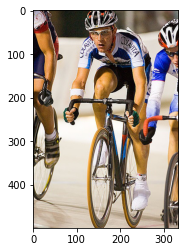

768


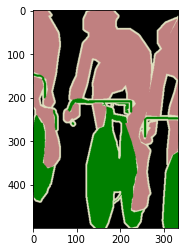

torch.Size([3, 475, 475])
torch.Size([1, 21, 475, 475])
@@@@@
(21, 475, 475)
(475, 475)
PPPPP
[0, 0, 0, 128, 0, 0, 0, 128, 0, 128, 128, 0, 0, 0, 128, 128, 0, 128, 0, 128, 128, 128, 128, 128, 64, 0, 0, 192, 0, 0, 64, 128, 0, 192, 128, 0, 64, 0, 128, 192, 0, 128, 64, 128, 128, 192, 128, 128, 0, 64, 0, 128, 64, 0, 0, 192, 0, 128, 192, 0, 0, 64, 128, 128, 64, 128, 0, 192, 128, 128, 192, 128, 64, 64, 0, 192, 64, 0, 64, 192, 0, 192, 192, 0, 64, 64, 128, 192, 64, 128, 64, 192, 128, 192, 192, 128, 0, 0, 64, 128, 0, 64, 0, 128, 64, 128, 128, 64, 0, 0, 192, 128, 0, 192, 0, 128, 192, 128, 128, 192, 64, 0, 64, 192, 0, 64, 64, 128, 64, 192, 128, 64, 64, 0, 192, 192, 0, 192, 64, 128, 192, 192, 128, 192, 0, 64, 64, 128, 64, 64, 0, 192, 64, 128, 192, 64, 0, 64, 192, 128, 64, 192, 0, 192, 192, 128, 192, 192, 64, 64, 64, 192, 64, 64, 64, 192, 64, 192, 192, 64, 64, 64, 192, 192, 64, 192, 64, 192, 192, 192, 192, 192, 32, 0, 0, 160, 0, 0, 32, 128, 0, 160, 128, 0, 32, 0, 128, 160, 0, 128, 32, 128, 128, 160,

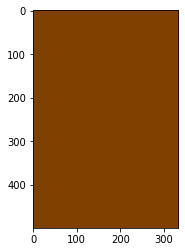

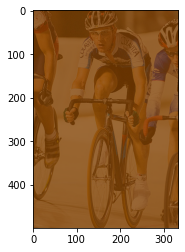

In [55]:
img_index = 4

# 1. 元画像の表示
image_file_path = val_img_list[img_index]
img_original = Image.open(image_file_path)   # [高さ][幅][色RGB]
img_width, img_height = img_original.size
plt.imshow(img_original)
plt.show()

# 2. 正解アノテーション画像の表示
anno_file_path = val_anno_list[img_index]
anno_class_img = Image.open(anno_file_path)   # [高さ][幅][色RGB]
p_palette = anno_class_img.getpalette()
print(len(p_palette))
plt.imshow(anno_class_img)
plt.show()

# 3. PSPNetで推論する
net.eval()
img, anno_class_img = val_dataset.__getitem__(img_index)
print(img.shape)
x = img.unsqueeze(0)  # ミニバッチ化：torch.Size([3, 475, 475]) -> torch.Size([1, 3, 475, 475])
outputs = net(x)
y = outputs[0]  # AuxLoss側は無視
print(y.shape)

# 4. PSPNetの出力から最大クラスを求め、カラーパレット形式にし、画像サイズを元に戻す
y = y[0].detach().numpy()  # y：torch.Size([1, 21, 475, 475])
print('@@@@@')
print(y.shape)
y = np.argmax(y, axis=0)
print(y.shape) # size=[475, 475], 各マスに対応するラベル番号が振られている
print('PPPPP')
print(p_palette)
anno_class_img = Image.fromarray(np.uint8(y), mode="P") #ラベル番号が振られた画像
anno_class_img = anno_class_img.resize((img_width, img_height), Image.NEAREST) #元画像大きさにリサイズ
print(anno_class_img.size)
anno_class_img.putpalette(p_palette) #パレットを割り振る
plt.imshow(anno_class_img)
plt.show()

# 5. 画像を透過させて重ねる
trans_img = Image.new('RGBA', anno_class_img.size, (0, 0, 0, 0))
anno_class_img = anno_class_img.convert('RGBA')  # カラーパレット形式をRGBAに変換

for x in range(img_width):
    for y in range(img_height):
        # 推論結果画像のピクセルデータを取得
        pixel = anno_class_img.getpixel((x, y))
        r, g, b, a = pixel

        # (0, 0, 0)の背景ならそのままにして透過させる
        if pixel[0] == 0 and pixel[1] == 0 and pixel[2] == 0:
            continue
        else:
            # それ以外の色は用意した画像にピクセルを書き込む
            trans_img.putpixel((x, y), (r, g, b, 200))
            # 200は透過度の大きさを指定している

result = Image.alpha_composite(img_original.convert('RGBA'), trans_img)
plt.imshow(result)
plt.show()